In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33

path = "2205.02081/SLY4.csv"


# DIMENSIONS CHECKED
def lamba_metric(M, R):
    return -np.log((1-2*G*M/(c**2*R)))

def df_to_ep(df):
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*((2.99792458e10)**2)
    pressure = p*((2.99792458e10)**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value= "extrapolate", kind = "cubic")
    return f_e_smooth

def get_pe(p, e):
    f_e_smooth = interp1d(e, p, fill_value=(0, 0), kind = "cubic", bounds_error=True)
    return f_e_smooth

In [4]:
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))
def _b(r, M):
    return (G*M)/((c**2)*r)
def _dvdr(r, Q, lamda):
    return (2/r) * np.exp(lamda) * Q
def _Q(r, P, M):
    frac = (4 * np.pi * G * (r**2)*P)/(c**4)
    return _b(r, M) + frac
def _dPdr(r, P, M, e):    
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return -1 * (e+P) * G/(c**2) * num/dem

In [5]:
def _dWdlnr(r, W, U, Q, lamda, l, omega, v, c_ad2_inv):
    term1 = -1*(l+1)*( W - l * np.exp(v + lamda/2) * U)
    frac = -1 * ((omega*r)**2) * (np.exp(lamda/2)*(c_ad2_inv))
    term2 = frac * (U - np.exp(lamda/2)*Q*W*(c**2)/((omega*r)**2))
    return term1 + term2
def _dUdlnr(r, W, U, lamda, l, v):
    return np.exp(lamda/2 - v) * (W - l*(np.exp(v-lamda/2))*U)

In [6]:
df = pd.read_csv(path)
e, p = df_to_ep(df)
p_max = max(p)
p_min = max(1*(c**2), min(p)) # 10 orders of magnitude is "surface" 
EOS = get_ep(e, p)

def dedP_helper(p, e):
    return np.gradient(e, p), e

def dedP(p, e):
    dedp_helper, e_arr = dedP_helper(p, e)
    return interp1d(e_arr, dedp_helper, fill_value="extrapolate", kind = "cubic")

dedp = dedP(p, e)

def drhodP(e, dedp = dedp):
    return (c**-2) * dedp(e)

In [7]:
def coupledTOV(r, VEC, init_params):
    P, M, v, W, U = VEC
    EOS, l, omega, dedp_EQ = init_params
    if P < p_min: 
        return None
    if P > p_max:
        return None
    if 2*_b(r, M) > 1:
        return None
    lamda = np.log(1/(1-2*_b(r, M)))
    Q = _Q(r, P, M)
    e = EOS(P) 
    c_ad2_inv = drhodP(e)
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    dvdr = _dvdr(r, Q, lamda)
    dWdlnr = _dWdlnr(r, W, U, Q, lamda, l, omega, v, c_ad2_inv)
    dUdlnr = _dUdlnr(r, W, U, lamda, l, v)
    dWdr = dWdlnr * 1/r
    dUdr = dUdlnr * 1/r
    ret = [dPdr, dMdr, dvdr, dWdr, dUdr]
    return ret

In [8]:
def tov(EOS, init_VEC, r_i, p_min, omega, dedp_EQ, progress = False, 
        l=2, n_iter_max = 2000):
    init_params = [EOS, l, omega, dedp_EQ]
    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('LSODA')
#     r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('VODE')
    r.set_initial_value(init_VEC, r_i)
    results = []
    r_list = []
    i = 0
    r_max = 20 * km2cm
    max_iter = n_iter_max
    dr_init = r_max/max_iter
    dr_compute = 10000
    if progress:
        pbar = tqdm(total=max_iter)
    while r.successful() and (r.y[0] >= p_min):
        i+=1
        dr = min(dr_init, dr_compute)
        integral = r.integrate(r.t+dr)
        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
        if (r.y[0] < p_min):
            break
        if not r.successful():
            break
        results.append(integral)
        r_list.append(r.t+dr)
    if progress:
        pbar.close()
    
    results = np.array(results, dtype = float)
    p, m, v, w, u = results.T
    r = np.array(r_list)
    return p, m, r, v, w, u

In [9]:
# Load EOS
df = pd.read_csv(path)
e, p = df_to_ep(df)
EOS = get_ep(e, p)
# Initial Conditions
km2cm = 1e5
r_i = 1e-20
p0 = p[-92]
# p0 = p[-27]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = EOS(p_c)
m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3
omega = 2.39678e3*(2*np.pi) #Arbitrary guess
l=2
v0 = -1 # Two step integration optimization: similar to phi previously.
W0 = 1
U0 = W0/(l * np.exp(v0))

dedp_EQ = None

init_VEC = [p_c, m0, v0, W0, U0]


# Integrate
p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, 
                           omega, dedp_EQ, progress = True, 
                           l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
u_R = u[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(v_R)

# DIMENSIONED CHECKED
def boundary_wu(r_R, m_R, omega, w_R, u_R):
    frac1 = (omega**2 * r_R ** 3)/(G*m_R)
    return frac1 * np.sqrt(1-(2*G*m_R)/(r_R * (c**2))) - w_R/u_R

print("== First Integration == ")
print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
print(f"Interior Surface: {interior:.8f}")
print(f"Exterior Surface: {schild:.8f}")
print(f"v0 Round 1: {v0}")
print(f"Lamda Round 1: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wu(r_R, m_R, omega, w_R, u_R)}")

# Computer new v0, W0, U0
v_ext = -lamba_metric(m_R, r_R)
v_int = v_R #At surface
delta_v = v_int - v_ext
v0 =  v0 - delta_v

U0 = W0/(l * np.exp(v0))
init_VEC = [p_c, m0, v0, W0, U0]
time.sleep(0.2)

p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, omega,
                           dedp_EQ,
                           progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
u_R = u[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(v_R)

print("== Corrected Integration == ")
print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
print(f"Interior Surface: {interior:.8f}")
print(f"Exterior Surface: {schild:.8f}")
print(f"v0 Round 2: {v0}")
print(f"Lamda Round 2: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wu(r_R, m_R, omega, w_R, u_R)}")


== First Integration == 
Star has mass 1.378 Msun and radius 11.700km
Interior Surface: 0.58786444
Exterior Surface: 0.65218567
v0 Round 1: -1
Lamda Round 1: 0.4274259928249778
Boundary Term: -224.04264233182622



== Corrected Integration == 
Star has mass 1.378 Msun and radius 11.700km
Interior Surface: 0.65218584
Exterior Surface: 0.65218560
v0 Round 2: -0.8961670990810333
Lamda Round 2: 0.4274260946313145
Boundary Term: -148.38017409700586


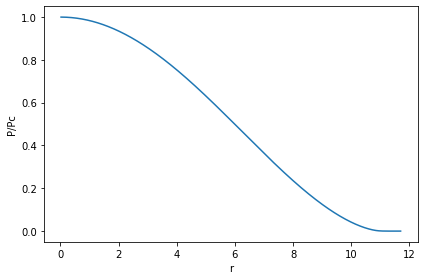

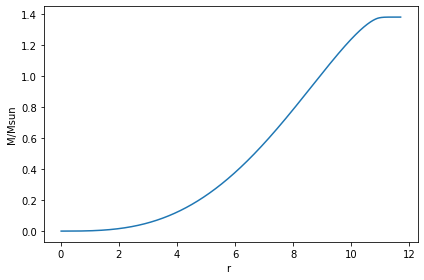

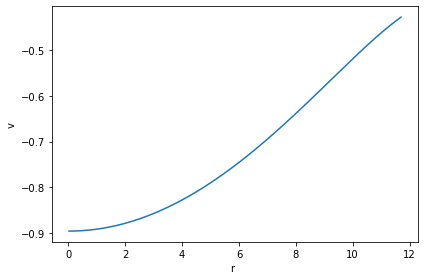

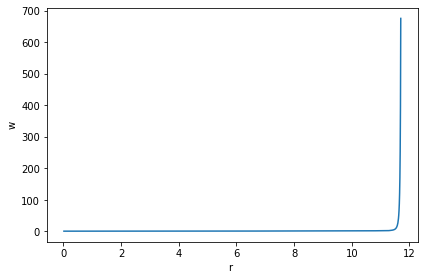

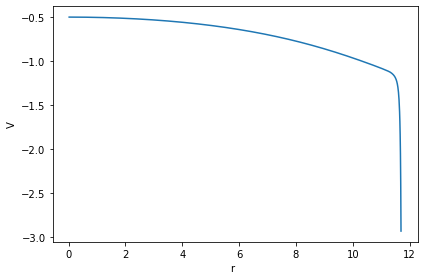

In [10]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, -u*np.exp(v))
plt.xlabel("r ")
plt.ylabel("V")
plt.show()

<IPython.core.display.Javascript object>


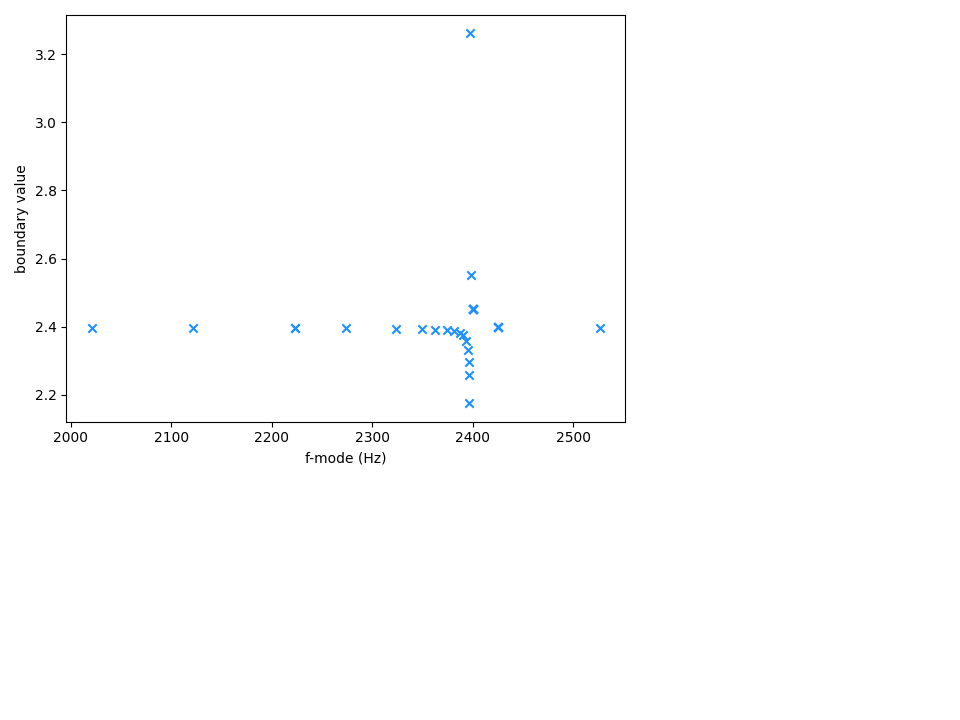

 final_simplex: (array([[15059.32309622],
       [15056.84297054]]), array([2.1758126 , 2.25998581]))
           fun: 2.1758126018477957
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 31
           nit: 15
        status: 2
       success: False
             x: array([15059.32309622])

omega: 15059
fmode: 2396.77 Hz


In [11]:
# Delete when shifting over to python
old_backend = mpl.get_backend() 
%matplotlib notebook 
# ====================================================================================
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
plt.xlabel("f-mode (Hz)")
plt.ylabel("boundary value")

def minimize_boundary(params, p = p, EOS = EOS):
    # Repeat integration
    omega = params

    # Integrate
    p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, omega,dedp_EQ, l = l)

    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    u_R = u[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx] 

    loss = np.log10(abs(boundary_wu(r_R, m_R, omega, w_R, u_R)))
    ax.scatter(omega/(2*np.pi), loss, color = "dodgerblue", marker = "x")
    fig.canvas.draw()
    return loss

omega_guess = (2*np.pi) * (0.78e3 + 30e-6 * np.sqrt(m_R/(r_R**3)))
init_guess = [omega_guess]

res = minimize(minimize_boundary, x0 = init_guess, method='Nelder-Mead', 
               options = {"disp": True, "maxiter":15})

mpl.use(old_backend) # Delete when shifting over to python
display(res)
omg = res.x[0]
f = omg/(2*np.pi)
print(f"omega: {omg:.0f}")
print(f"fmode: {f:.2f} Hz")

In [12]:
0.78e3 + 25e-6 * np.sqrt(m_R/(r_R**3)) #ArXiv 1501.02970

1814.156845238927

In [13]:
# # Delete when shifting over to python
# old_backend = mpl.get_backend() 
# %matplotlib notebook 
# # ====================================================================================
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()
# fig.show()
# fig.canvas.draw()
# plt.xlabel("f-mode (Hz)")
# plt.ylabel("boundary value")

# def plot_boundary(omega, p = p, EOS = EOS):
#     # Repeat integration

#     # Integrate
#     p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, omega, dedp_EQ, l = l)
    
#     max_idx = np.argmax(m)
#     m_R = m.max() # In units of msun
#     r_R = r_arr[max_idx]# In units of km
    
#     p_R = p[max_idx] #cgs
#     ec_R = EOS(p_R) #cgs
#     u_R = u[max_idx] 
#     v_R = v[max_idx] 
#     w_R = w[max_idx] 
    
# #     print(w_R/u_R)
    
#     bc1 = boundary_wu(r_R, m_R, omega, w_R, u_R)
#     ax.scatter(omega/(2*np.pi), bc1, color = "dodgerblue", marker = "x")
#     fig.canvas.draw()
#     return None

# omega_guess = np.linspace(0.01*(2*np.pi), 15e3*(2*np.pi), int(1e2))
    
# for omega in tqdm(omega_guess):
#     plot_boundary(omega)

# mpl.use(old_backend) # Delete when shifting over to python